In [7]:
#Импорт зависимостей
from tensorflow import keras as K
import tensorflow as tf
import numpy as np
import string
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#Разархивируем данные и посмотрим что внутри
!tar -xf aclImdb_v1.tar.gz
#!tar -xf '/content/drive/MyDrive/Colab Notebooks/aclImdb_v1.tar.gz'
print(os.listdir('aclImdb/'))
print(os.listdir('aclImdb/train'))
print(os.listdir('aclImdb/test'))

['test', 'imdbEr.txt', 'README', 'train', 'imdb.vocab']
['unsup', 'labeledBow.feat', 'neg', 'pos', 'urls_neg.txt', 'urls_unsup.txt', 'unsupBow.feat', 'urls_pos.txt']
['labeledBow.feat', 'neg', 'pos', 'urls_neg.txt', 'urls_pos.txt']


In [9]:
#Удалим папку unsup, оставим только pos и neg
shutil.rmtree('aclImdb/train/unsup')

In [10]:
#Константы
BATCH_SIZE = 128
MAX_FEATURES = 25000
EMBEDDING_DIM = 256
SEQUENCE_LENGTH = 1000
EPOCHS = 30

In [11]:
#Создадим дадасет для обучения
raw_train_ds = K.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
    seed=1,
    validation_split=0.2,
    subset="training",
)

raw_val_ds = K.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size = BATCH_SIZE,
    seed = 1,
    validation_split = 0.2,
    subset = "validation",
    )

raw_test_ds = K.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=BATCH_SIZE)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [12]:
#Посмотрим на один элемент батча
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(1):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])


b'Stupid and just plain weird movie about some kid who becomes traumatized when he finds out Santa isn\'t real (???). He grows up and becomes an adult (Brandon Maggart) who makes lists of people who are naughty or nice. One Christmas he snaps and sets out to kill the naughty people--dressed as Santa of course.<br /><br />Boring and just plain bad killer Santa movie. If you\'re looking for gore, it\'s not here. Only a few of the murders are shown and they\'re not that gory with VERY fake effects. Most of the movie just contains Brandon Maggart talking to himself and slowly going crazy. The script is trite, the acting is terrible and it leads to an ending which had me staring slack-jawed at the TV. Seriously, I had to rewind the tape and watch it again to make sure I wasn\'t hallucinating! Really REALLY poor ending.<br /><br />If you want a scary Christmas flick rent "Black Christmas" (the original 70s version---NOT the terrible remake). Avoid this one at all costs.'
0


In [13]:
#Создадим слой векторизации, который переводит текст в вектор.
#Приведем все слова к нижнему регистру, уберем пунктуацию
vectorize_layer = K.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)

# Удалим класс, оставим только текст
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)


In [14]:
#В случае, если на конец эпохи точность будет выше 97% или
#валидационный лосс прекратит расти, закончим обучение
class myCallback(K.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.97):
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True
mycallback = myCallback()
earlystop = K.callbacks.EarlyStopping(monitor='val_loss', patience=4)

#сохраним лучшую модель №1
checkpointer1 = K.callbacks.ModelCheckpoint(filepath="export_model1",
                                            monitor="val_loss",
                                            verbose=0,
                                            save_best_only=True)

#сохраним лучшую модель №2
checkpointer2 = K.callbacks.ModelCheckpoint(filepath="export_model2",
                                            monitor="val_loss",
                                            verbose=0,
                                            save_best_only=True)


In [15]:
#Функция для отображения хода обучения
plt.style.use('ggplot')

def plot_history(history, metric):
    acc = history.history[f'{metric}']
    val_acc = history.history[f'val_{metric}']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label=f'Training {metric}')
    plt.plot(x, val_acc, 'r', label=f'Validation {metric}')
    plt.title(f'Training and validation {metric}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [16]:
#Создадим модель для "звездного рейтинга"

In [17]:
#Составим датасет
pos_train = os.listdir('aclImdb/train/pos')
neg_train = os.listdir('aclImdb/train/neg')
pos_test = os.listdir('aclImdb/test/pos')
neg_test = os.listdir('aclImdb/test/neg')

pos_train_y = []
pos_train_x = []
neg_train_y = []
neg_train_x = []
pos_test_y = []
pos_test_x = []
neg_test_y =[]
neg_test_x = []

for file in pos_train:
    with open('aclImdb/train/pos/' + file, encoding = 'utf-8') as f:
        pos_train_x.append(f.read())
    file = int((file.split('_')[1]).split('.')[0])
    pos_train_y.append(file)
for file in neg_train:
    with open('aclImdb/train/neg/' + file, encoding = 'utf-8') as f:
        neg_train_x.append(f.read())
    file = int((file.split('_')[1]).split('.')[0])
    neg_train_y.append(file)
for file in pos_test:
    with open('aclImdb/test/pos/' + file, encoding = 'utf-8') as f:
        pos_test_x.append(f.read())
    file = int((file.split('_')[1]).split('.')[0])
    pos_test_y.append(file)
for file in neg_test:
    with open('aclImdb/test/neg/' + file, encoding = 'utf-8') as f:
        neg_test_x.append(f.read())
    file = int((file.split('_')[1]).split('.')[0])
    neg_test_y.append(file)

train_ds_x = pos_train_x + neg_train_x
train_ds_y = pos_train_y + neg_train_y
test_ds_x = pos_test_x + neg_test_x
test_ds_y = pos_test_y + neg_test_y

train_ds = tf.data.Dataset.from_tensor_slices((train_ds_x, train_ds_y)).shuffle(25000).batch(BATCH_SIZE)
            
train_size = int(0.8 * len(train_ds))
train_ds1 = train_ds.take(train_size)
val_ds1 = train_ds.skip(train_size)
test_ds1 = tf.data.Dataset.from_tensor_slices((test_ds_x, test_ds_y)).shuffle(25000).batch(BATCH_SIZE)
            


In [18]:
#Модель "звездного рейтинга"
model1 = K.Sequential(
    [
        K.Input(shape=(1,), dtype="string"),
        vectorize_layer,
        K.layers.Embedding(MAX_FEATURES, EMBEDDING_DIM),
        K.layers.Dropout(0.5),
        K.layers.Bidirectional(K.layers.LSTM(64, return_sequences=True)),
        K.layers.Bidirectional(K.layers.LSTM(64,)),
        K.layers.Dense(128, activation="relu"),
        K.layers.Dropout(0.5),
        K.layers.Dense(1, name="predictions"),
    ])

model1.compile(loss="MSE",
               optimizer='Adam',
               metrics=["MSE"],
             )

In [19]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1000)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1000, 256)         6400000   
                                                                 
 dropout (Dropout)           (None, 1000, 256)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 128)        164352    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                        

In [20]:
#Запустим обучение
history1 = model1.fit(train_ds1,
                     validation_data = val_ds1,
                     epochs = EPOCHS,
                     callbacks = [earlystop,checkpointer1],
                     )

Epoch 1/30
156/156 [==============================] - ETA: 0s - loss: 11.6568 - MSE: 11.6568

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 142s 842ms/step - loss: 11.6568 - MSE: 11.6568 - val_loss: 4.6470 - val_MSE: 4.6470
Epoch 2/30
156/156 [==============================] - ETA: 0s - loss: 5.3928 - MSE: 5.3928

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 128s 818ms/step - loss: 5.3928 - MSE: 5.3928 - val_loss: 3.1217 - val_MSE: 3.1217
Epoch 3/30
156/156 [==============================] - ETA: 0s - loss: 4.2522 - MSE: 4.2522

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 127s 816ms/step - loss: 4.2522 - MSE: 4.2522 - val_loss: 2.3326 - val_MSE: 2.3326
Epoch 4/30
156/156 [==============================] - ETA: 0s - loss: 3.3844 - MSE: 3.3844

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 127s 816ms/step - loss: 3.3844 - MSE: 3.3844 - val_loss: 1.8492 - val_MSE: 1.8492
Epoch 5/30
156/156 [==============================] - ETA: 0s - loss: 2.9220 - MSE: 2.9220

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 127s 816ms/step - loss: 2.9220 - MSE: 2.9220 - val_loss: 1.6485 - val_MSE: 1.6485
Epoch 6/30
156/156 [==============================] - ETA: 0s - loss: 2.6537 - MSE: 2.6537

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 128s 819ms/step - loss: 2.6537 - MSE: 2.6537 - val_loss: 1.4913 - val_MSE: 1.4913
Epoch 7/30
156/156 [==============================] - ETA: 0s - loss: 2.4418 - MSE: 2.4418

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 127s 816ms/step - loss: 2.4418 - MSE: 2.4418 - val_loss: 1.2236 - val_MSE: 1.2236
Epoch 8/30
156/156 [==============================] - ETA: 0s - loss: 2.2010 - MSE: 2.2010

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 128s 822ms/step - loss: 2.2010 - MSE: 2.2010 - val_loss: 1.1473 - val_MSE: 1.1473
Epoch 9/30
156/156 [==============================] - ETA: 0s - loss: 1.9622 - MSE: 1.9622

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 127s 813ms/step - loss: 1.9622 - MSE: 1.9622 - val_loss: 0.9460 - val_MSE: 0.9460
Epoch 10/30
156/156 [==============================] - ETA: 0s - loss: 1.8857 - MSE: 1.8857

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 128s 820ms/step - loss: 1.8857 - MSE: 1.8857 - val_loss: 0.8763 - val_MSE: 0.8763
Epoch 11/30
156/156 [==============================] - 100s 638ms/step - loss: 1.7891 - MSE: 1.7891 - val_loss: 1.1800 - val_MSE: 1.1800
Epoch 12/30
156/156 [==============================] - 99s 634ms/step - loss: 1.6406 - MSE: 1.6406 - val_loss: 1.0712 - val_MSE: 1.0712
Epoch 13/30
156/156 [==============================] - ETA: 0s - loss: 1.6635 - MSE: 1.6635

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 127s 817ms/step - loss: 1.6635 - MSE: 1.6635 - val_loss: 0.6921 - val_MSE: 0.6921
Epoch 14/30
156/156 [==============================] - 99s 635ms/step - loss: 1.5941 - MSE: 1.5941 - val_loss: 0.7130 - val_MSE: 0.7130
Epoch 15/30
156/156 [==============================] - 99s 634ms/step - loss: 1.9221 - MSE: 1.9221 - val_loss: 0.8564 - val_MSE: 0.8564
Epoch 16/30
156/156 [==============================] - 99s 635ms/step - loss: 1.6067 - MSE: 1.6067 - val_loss: 0.7923 - val_MSE: 0.7923
Epoch 17/30
156/156 [==============================] - ETA: 0s - loss: 1.5437 - MSE: 1.5437

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 128s 822ms/step - loss: 1.5437 - MSE: 1.5437 - val_loss: 0.6755 - val_MSE: 0.6755
Epoch 18/30
156/156 [==============================] - ETA: 0s - loss: 1.4283 - MSE: 1.4283

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 128s 818ms/step - loss: 1.4283 - MSE: 1.4283 - val_loss: 0.5968 - val_MSE: 0.5968
Epoch 19/30
156/156 [==============================] - ETA: 0s - loss: 1.3385 - MSE: 1.3385

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 128s 821ms/step - loss: 1.3385 - MSE: 1.3385 - val_loss: 0.5093 - val_MSE: 0.5093
Epoch 20/30
156/156 [==============================] - ETA: 0s - loss: 1.2638 - MSE: 1.2638

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 127s 815ms/step - loss: 1.2638 - MSE: 1.2638 - val_loss: 0.4730 - val_MSE: 0.4730
Epoch 21/30
156/156 [==============================] - ETA: 0s - loss: 1.1674 - MSE: 1.1674

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 127s 815ms/step - loss: 1.1674 - MSE: 1.1674 - val_loss: 0.4013 - val_MSE: 0.4013
Epoch 22/30
156/156 [==============================] - 100s 638ms/step - loss: 1.1765 - MSE: 1.1765 - val_loss: 2.2117 - val_MSE: 2.2117
Epoch 23/30
156/156 [==============================] - 99s 637ms/step - loss: 1.3426 - MSE: 1.3426 - val_loss: 0.4751 - val_MSE: 0.4751
Epoch 24/30
156/156 [==============================] - ETA: 0s - loss: 1.1282 - MSE: 1.1282

INFO:tensorflow:Assets written to: export_model1/assets


INFO:tensorflow:Assets written to: export_model1/assets


156/156 [==============================] - 128s 819ms/step - loss: 1.1282 - MSE: 1.1282 - val_loss: 0.3513 - val_MSE: 0.3513
Epoch 25/30
156/156 [==============================] - 99s 635ms/step - loss: 1.0734 - MSE: 1.0734 - val_loss: 0.3746 - val_MSE: 0.3746
Epoch 26/30
156/156 [==============================] - 100s 639ms/step - loss: 1.0395 - MSE: 1.0395 - val_loss: 0.4056 - val_MSE: 0.4056
Epoch 27/30
156/156 [==============================] - 99s 638ms/step - loss: 1.1678 - MSE: 1.1678 - val_loss: 0.6328 - val_MSE: 0.6328
Epoch 28/30
156/156 [==============================] - 99s 637ms/step - loss: 0.9939 - MSE: 0.9939 - val_loss: 0.3729 - val_MSE: 0.3729


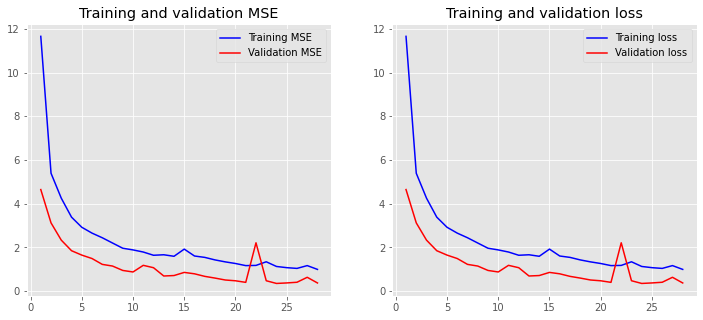

In [21]:
plot_history(history1, 'MSE')

In [22]:
#Оценим метрику на тестовом датасете
loaded_model1 = K.models.load_model('export_model1')
loaded_model1.evaluate(test_ds1)

196/196 [==============================] - 42s 205ms/step - loss: 5.8294 - MSE: 5.8294


[5.829432010650635, 5.829432010650635]

In [27]:
for text_batch, label_batch in test_ds1.take(1):
    pred = loaded_model1.predict(text_batch)
    for i in range(10):
        print(f'Review:{text_batch.numpy()[i]}')
        print(f'True label:{label_batch.numpy()[i]}')
        print(f'Predict label:{int(loaded_model1.predict(text_batch)[i][0] + (0.5))}')

Review:b"I went to see this thinking it would be a great comedy and a comeback for Robin Williams, but when I saw it I realized I had bee lied to by advertisers as this is more drama than comedy, although it has a few really good laughs in it. It felt like I was watching two movies. One was a funny romp with Robin Williams that should have been the whole basin for the movie anyway, but you also get a techno thriller movie with political angst in the middle. I really don't know how to classify this film. But I can tell you it was good and I did laugh, not as much as I had hoped, but at least Williams is back in the right direction. See this but know before going it is not all comedy and is a little intense."
True label:7
Predict label:7
Review:b"One of the best! As being a fan of the civil war, I was very pleased with the first installment of the North and South trilogy. Patrick Swayze gives and extraordinary performance, as well as James Reed and Leslie Ann Down. In watching this fabul

In [28]:
#Создадим модель
model2 = K.Sequential(
    [
        model1,
        K.layers.Activation ("sigmoid")
    ])

In [29]:
#Скомпилируем ее
model2.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["acc"],
             )
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1)                 6679809   
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 6,679,809
Trainable params: 6,679,809
Non-trainable params: 0
_________________________________________________________________


In [30]:
#Запустим обучение
history2 = model2.fit(raw_train_ds,
                    validation_data= raw_val_ds,
                    epochs = EPOCHS,
                    callbacks = [mycallback,earlystop,checkpointer2])

Epoch 1/30
157/157 [==============================] - ETA: 0s - loss: 0.1201 - acc: 0.9406

INFO:tensorflow:Assets written to: export_model2/assets


INFO:tensorflow:Assets written to: export_model2/assets


157/157 [==============================] - 149s 902ms/step - loss: 0.1201 - acc: 0.9406 - val_loss: 0.0333 - val_acc: 0.9910
Epoch 2/30
157/157 [==============================] - ETA: 0s - loss: 0.0296 - acc: 0.9916
Reached 97.0% accuracy so cancelling training!
157/157 [==============================] - 101s 642ms/step - loss: 0.0296 - acc: 0.9916 - val_loss: 0.0437 - val_acc: 0.9862


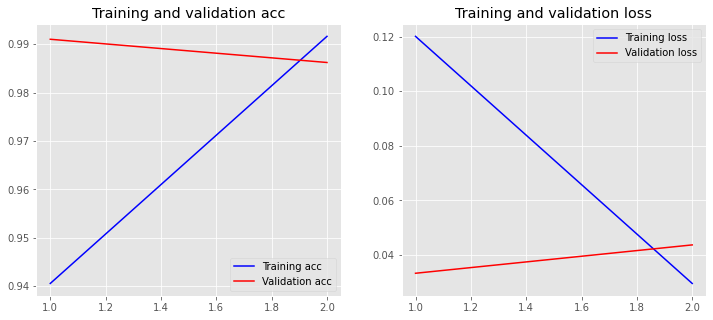

In [31]:
plot_history(history2, 'acc')

In [32]:
#Оценим работу модели на тестовом датасете
loaded_model2 = K.models.load_model('export_model2')
loaded_model2.evaluate(raw_test_ds)

196/196 [==============================] - 44s 213ms/step - loss: 0.7579 - acc: 0.8292


[0.7579371333122253, 0.8291599750518799]

In [33]:
#Посмотрим на одном примере
for text_batch, label_batch in raw_train_ds.take(1):
    pred = loaded_model2.predict(text_batch)
    for i in range(1):
        print(f'Review:{text_batch.numpy()[i]}')
        print(f'True label:{label_batch.numpy()[i]}')
        print(f'Predict label:{pred[i][0]>=0.5}')

Review:b'This movie starts out promisingly, with an early scene in which Frank Morgan advises against Gary Cooper\'s marriage to his daughter, Anita Louise. Frank Morgan, playing an unabashed gold-digger, loudly complains to Cooper about his perceived penury at the hands of his family - including his daughter, Anita Louise. I am a fan of all 3 actors. Frank Morgan is (to my mind) a Hollywood treasure, Cooper a legend, and Louise a very lovely, versatile and under-appreciated actress seldom seen in the leading role. I also have nothing against Teresa Wright, and while not blessed with great range, she usually delivers heart-warming performances.<br /><br />From a promising opening, the story slides downhill all the way to the end. I found nothing humorous about burning down the home of Cooper\'s would-be in-laws. The butler in such a fastidious, non-smoking household would never just blithely walk away, allowing Cooper to continue smoking, or alternatively he would certainly supply him 